# Linear VMM (Vessel Maneuvering Model)

# Purpose
Implementing according to:
Matusiak, Jerzy. Dynamics of a Rigid Ship. Aalto University, 2017. https://aaltodoc.aalto.fi:443/handle/123456789/24408.

# Methodology
Define the problem using SymPy

# Setup

In [2]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src import symbols
from src.symbols import *
from src.linear_vmm_equations import *

import src.linear_vmm_equations as eq
import src.models.linear_vmm as model




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
symbols.df_parameters

,coord,dof,state,symbol,brix,brix_lambda
Xu,u,X,,X_{u},NaN,NaN
Xudot,u,X,dot,X_{\dot{u}},NaN,NaN
Xv,v,X,,X_{v},NaN,NaN
Xvdot,v,X,dot,X_{\dot{v}},NaN,NaN
Xr,r,X,,X_{r},NaN,NaN
Xrdot,r,X,dot,X_{\dot{r}},NaN,NaN
Xdelta,\delta,X,,X_{\delta},NaN,NaN
Xdeltadot,\delta,X,dot,X_{\dot{\delta}},NaN,NaN
Yu,u,Y,,Y_{u},NaN,NaN
Yudot,u,Y,dot,Y_{\dot{u}},NaN,NaN


In [4]:
Math(vlatex(eq.X_eq))

<IPython.core.display.Math object>

In [5]:
Math(vlatex(eq.Y_eq))

<IPython.core.display.Math object>

In [6]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [7]:
#u1d_eq = sp.Eq(u.diff(), sp.solve(X_eq, u.diff())[0])
#Math(vlatex(u1d_eq))

In [8]:
#v1d_eq = sp.Eq(v.diff(), sp.solve(Y_eq, v.diff())[0])
#Math(vlatex(v1d_eq))

In [9]:
#r1d_eq = sp.Eq(r.diff(), sp.solve(N_eq, r.diff())[0])
#Math(vlatex(r1d_eq))

## Prime system

In [10]:
symbols.df_prime

,length,mass,density,inertia_moment,time,area,angle,-,linear_velocity,angular_velocity,linear_acceleration,angular_acceleration,force,moment
denominator,L,0.5*L**3*rho,0.5*rho,0.5*L**5*rho,L/U,L**2,1,1,U,U/L,U**2/L,U**2/L**2,0.5*L**2*U**2*rho,0.5*L**3*U**2*rho
lambda,<function _lambdifygenerated at 0x0000025C91DD...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E7...


## Ship parameters

In [11]:
T_ =10
L_ = 200
CB_ = 0.7
B_ = 30
rho_ = 1025
m_ = T_*B_*L_*CB_*rho_

ship_parameters = {
    'T' : (T_,'length'),
    'L' : (L_,'length'),
    'CB' :(CB_,'-'),
    'B' : (B_,'length'),
    'rho' : (rho_,'density'),
    'x_G' : (0,'length'),
    'm' : (m_,'mass'),
    'I_z': (0.2*m_*L_**2, 'inertia_moment'),
    
}

df_ship_parameters = pd.DataFrame(data = ship_parameters, index=['value','unit'])
df_ship_parameters.loc['lambda'] = df_prime.loc['lambda',df_ship_parameters.loc['unit']].values

In [12]:
for key in ['denominator','lambda']:
    df_ship_parameters.loc[key] = df_prime[df_ship_parameters.loc['unit']].loc[key].values

In [13]:
def calculate_prime_ship(col, df_ship_parameters):
    denominator = run(function=col['lambda'], inputs=df_ship_parameters.loc['value'])
    prime = col['value'] / denominator
    return prime

In [14]:
df_ship_parameters.loc['prime'] = df_ship_parameters.apply(func=calculate_prime_ship, axis=0, df_ship_parameters=df_ship_parameters)

In [15]:
df_ship_parameters

,T,L,CB,B,rho,x_G,m,I_z
value,10,200,0.7,30,1025,0,43050000.0,344400000000.0
unit,length,length,-,length,density,length,mass,inertia_moment
lambda,<function _lambdifygenerated at 0x0000025C91DD...,<function _lambdifygenerated at 0x0000025C91DD...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91DD...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91DD...,<function _lambdifygenerated at 0x0000025C91E6...,<function _lambdifygenerated at 0x0000025C91E6...
denominator,L,L,1,L,0.5*rho,L,0.5*L**3*rho,0.5*L**5*rho
prime,0.05,1.0,0.7,0.15,2.0,0.0,0.0105,0.0021


In [16]:
def calculate_prime(row, df_ship_parameters):
    return run(function=row['brix_lambda'], inputs=df_ship_parameters.loc['value'])

df_parameters.loc[mask,'prime'] = df_parameters.loc[mask].apply(calculate_prime, df_ship_parameters=df_ship_parameters, axis=1)
df_parameters.loc['Ydelta','prime'] = 0.1  # Just guessing
df_parameters.loc['Ndelta','prime'] = 0.1  # Just guessing

In [17]:
df_parameters['prime'].fillna(0, inplace=True)
df_parameters

,coord,dof,state,symbol,brix,brix_lambda,prime
Xu,u,X,,X_{u},NaN,NaN,0.000000
Xudot,u,X,dot,X_{\dot{u}},NaN,NaN,0.000000
Xv,v,X,,X_{v},NaN,NaN,0.000000
Xvdot,v,X,dot,X_{\dot{v}},NaN,NaN,0.000000
Xr,r,X,,X_{r},NaN,NaN,0.000000
Xrdot,r,X,dot,X_{\dot{r}},NaN,NaN,0.000000
Xdelta,\delta,X,,X_{\delta},NaN,NaN,0.000000
Xdeltadot,\delta,X,dot,X_{\dot{\delta}},NaN,NaN,0.000000
Yu,u,Y,,Y_{u},NaN,NaN,0.000000
Yudot,u,Y,dot,Y_{\dot{u}},NaN,NaN,0.000000


In [19]:
model.u1d_lambda

<function _lambdifygenerated(I_z, Ndelta, Nr, Nrdot, Nu, Nudot, Nv, Nvdot, U, Xdelta, Xr, Xrdot, Xu, Xudot, Xv, Xvdot, Ydelta, Yr, Yrdot, Yu, Yudot, Yv, Yvdot, delta, m, r, u, v, x_G)>

In [20]:
model.v1d_lambda

<function _lambdifygenerated(I_z, Ndelta, Nr, Nrdot, Nu, Nudot, Nv, Nvdot, U, Xdelta, Xr, Xrdot, Xu, Xudot, Xv, Xvdot, Ydelta, Yr, Yrdot, Yu, Yudot, Yv, Yvdot, delta, m, r, u, v, x_G)>

In [21]:
states = {
    'u' : 10,
    'v' : 0.1,
    'r' : 0,
    #'u1d' : 0,
    #'v1d' : 0,
    #'r1d' : 0,
    
}

control = {
    'delta' : 0,
    'U' : 10.0,
}

inputs = dict(df_parameters['prime'])
inputs.update(dict(df_ship_parameters.loc['prime']))
inputs.update(states)
inputs.update(control)

run(function=model.v1d_lambda, inputs=inputs)

-0.06708183427940566

In [22]:
run(function=model.u1d_lambda, inputs=inputs)

0.0

<AxesSubplot:>

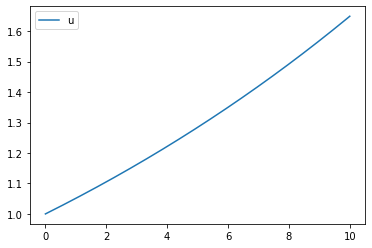

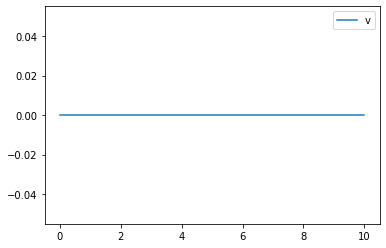

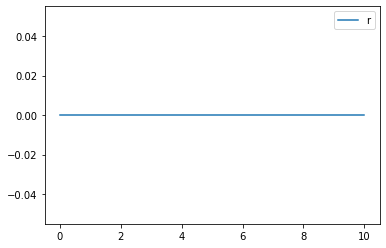

In [24]:
t = np.linspace(0,10,1000)


control = {
    'delta' : (0.0, 'angle'),
}

parameters = dict(df_parameters['prime'])

y0 = [
    10.0,  ## u
    0.0,  ## v
    0.0,  ## r
    #0,  ## ud1
    #0,  ## vd1
    #0,  ## rd1
]

solution = model.simulate(y0=y0, t=t, df_parameters=df_parameters, df_ship_parameters=df_ship_parameters, control=control)
#df_result_prime = pd.DataFrame(data=solution.y.T, columns = ['u','v','r','u1d','v1d','r1d'], index=t)
df_result_prime = pd.DataFrame(data=solution.y.T, columns = ['u','v','r'], index=t)

#df_result_prime['U'] = np.sqrt(df_result_prime['u']**2 + df_result_prime['v']**2)


df_result_prime.plot(y='u')
df_result_prime.plot(y='v')
df_result_prime.plot(y='r')



In [25]:
inputs_prime = dict(df_ship_parameters.loc['value'])
inputs_prime['U'] = np.sqrt(y0[0]**2 + y0[1]**2)  #Initial velocity

df_result = df_result_prime.copy()
df_result['u']*=run(df_prime.linear_velocity['lambda'], inputs_prime)
df_result['v']*=run(df_prime.linear_velocity['lambda'], inputs_prime)
df_result['r']*=run(df_prime.angular_velocity['lambda'], inputs_prime)
#df_result['u1d']*=run(df_prime.linear_acceleration['lambda'], inputs_prime)
#df_result['v1d']*=run(df_prime.linear_acceleration['lambda'], inputs_prime)
#df_result['r1d']*=run(df_prime.angular_acceleration['lambda'], inputs_prime)


In [26]:
df_result.head()

,u,v,r
0.00000,10.000000,0.0,0.0
0.01001,10.005006,0.0,0.0
0.02002,10.010015,0.0,0.0
0.03003,10.015026,0.0,0.0
0.04004,10.020040,0.0,0.0


<AxesSubplot:>

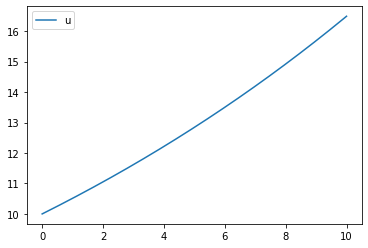

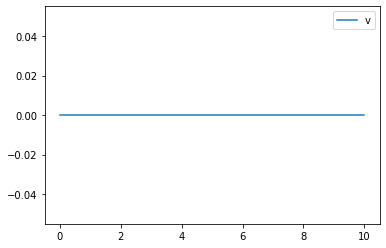

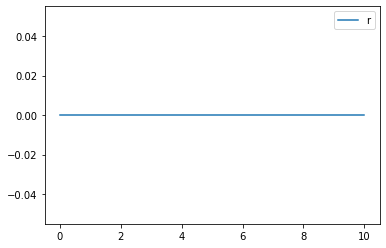

In [27]:
df_result.plot(y='u')
df_result.plot(y='v')
df_result.plot(y='r')